In [111]:
import nltk
import string
import matplotlib.pyplot as plt
import numpy as np
import heapq
import re
import math
import pandas as pd
from gensim.models import Word2Vec
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer, sent_tokenize, word_tokenize
from collections import Counter
from nltk import bigrams
from nltk import trigrams
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import display

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\benom\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\benom\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#The Text we will use: Harry Potter and the Goblet of Fire
with open("04 Harry Potter and the Goblet of Fire.txt", "r", encoding="utf-8") as file:
    HarryPotter = file.read()

print(HarryPotter[:1000])

HP 4 - Harry Potter and The Goblet of Fire

CHAPTER ONE


The villagers of Little Hangleton still called it “the Riddle House,” even though it had been many years since the Riddle family had lived there. It stood on a hill overlooking the village, some of its windows boarded, tiles missing from its roof, and ivy spreading unchecked over its face. Once a fine-looking manor, and easily the largest and grandest building for miles around, the Riddle House was now damp, derelict, and unoccupied.

The Little Hangletons all agreed that the old house was “creepy.” Half a century ago, something strange and horrible had happened there, something that the older inhabitants of the village still liked to discuss when topics for gossip were scarce. The story had been picked over so many times, and had been embroidered in so many places, that nobody was quite sure what the truth was anymore. Every version of the tale, however, started in the same place: Fifty years before, at daybreak on a fine summe

In [7]:
#Part 0: Splitting the book into Chapter Documents for TD-IDF and Term Doc Models

# Split text into chapters based on chapter headings
chapters = re.split(r'HP 4 - Harry Potter and The Goblet of Fire\s*\nCHAPTER\s+\w+', HarryPotter)
# The book title tells the code to look for that as the chapter breaks; the \s* removes zero or more spaces, \n is a newline, CHAPTER matches for the word Chapter, \w* matches for the chapter number


# Remove empty strings and clean up whitespace
chapters = [chapter.strip() for chapter in chapters if chapter.strip()]
#Chapter.strip() removes any leading, trailing, or newlines, The if statements remove chapters in the list comprehension that don't exist


# Print the number of chapters found
print(f"Total chapters found: {len(chapters)}")

# Display a preview of Chapter 1
print("\n--- Chapter 1 Sample ---\n")
print(chapters[10][:1000])  # Show first 1000 characters of Chapter 1

Total chapters found: 37

--- Chapter 1 Sample ---

There was a definite end-of-the-holidays gloom in the air when Harry awoke next morning. Heavy rain was still splattering against the window as he got dressed in jeans and a sweatshirt; they would change into their school robes on the Hogwarts Express.

He, Ron, Fred, and George had just reached the first-floor landing on their way down to breakfast, when Mrs. Weasley appeared at the foot of the stairs, looking harassed.

“Arthur!” she called up the staircase. “Arthur! Urgent message from the Ministry!”

Harry flattened himself against the wall as Mr. Weasley came clattering past with his robes on back-to-front and hurtled out of sight. When Harry and the others entered the kitchen, they saw Mrs. Weasley rummaging anxiously in the drawers - “I've got a quill here somewhere!” - and Mr. Weasley bending over the fire, talking to -

Harry shut his eyes hard and opened them again to make sure that they were working properly.

Amos Diggory'

In [69]:
# Part 1: Pre-processing
tokenizer = TweetTokenizer(preserve_case=False) #Initialize the tokenizer
token_chs = [tokenizer.tokenize(chapter) for chapter in chapters] #Need the for statement because we want tokenization on each chapter in the "chapters" variable. We didn't need this when it was a giant string

print(f"Total Amount of Chapters: {len(token_chs)}\n") #Total amount of chapters
print(token_chs[0][:50]) #Prints first 50 words in chapter 1 (can do for all chapters)


stop_words = set(stopwords.words('english'))
extra_punctuation = "“”‘’…"
every_punctuation = string.punctuation + extra_punctuation #Adds all punctuation plus important ones not included
filtered_chs = [
    [word for word in tokens if word not in stop_words and word not in every_punctuation]
    for tokens in token_chs
]
#Only words in their respective chapters that are not stop words or punctuation will show up

print(f"\nTotal Amount of Filtered Chapters: {len(filtered_chs)}\n")
print(filtered_chs[0][:50]) #You can compare with the above tokens WITH stop words, that this filtered set removes stop words and punctuation

Total Amount of Chapters: 37

['the', 'villagers', 'of', 'little', 'hangleton', 'still', 'called', 'it', '“', 'the', 'riddle', 'house', ',', '”', 'even', 'though', 'it', 'had', 'been', 'many', 'years', 'since', 'the', 'riddle', 'family', 'had', 'lived', 'there', '.', 'it', 'stood', 'on', 'a', 'hill', 'overlooking', 'the', 'village', ',', 'some', 'of', 'its', 'windows', 'boarded', ',', 'tiles', 'missing', 'from', 'its', 'roof', ',']

Total Amount of Filtered Chapters: 37

['villagers', 'little', 'hangleton', 'still', 'called', 'riddle', 'house', 'even', 'though', 'many', 'years', 'since', 'riddle', 'family', 'lived', 'stood', 'hill', 'overlooking', 'village', 'windows', 'boarded', 'tiles', 'missing', 'roof', 'ivy', 'spreading', 'unchecked', 'face', 'fine-looking', 'manor', 'easily', 'largest', 'grandest', 'building', 'miles', 'around', 'riddle', 'house', 'damp', 'derelict', 'unoccupied', 'little', 'hangletons', 'agreed', 'old', 'house', 'creepy', 'half', 'century', 'ago']


In [125]:
# Part 2: Word Frequency Model & Visualization
word_freq_model = [Counter(tokens) for tokens in filtered_chs] #Iterating on each token (the tokens of each word) for each chapter. It gives a clearer picture of each chapter instead of a general overview like we had

total_word_freq_model = Counter() #Initialize an empty counter to fill on for loop
#A model calculating word frequency for the entire book to compare on a chapter-by-chapter basis
for ch_freq in word_freq_model:
    total_word_freq_model.update(ch_freq) #A for loop that iterates each chapter in the first loop, but adds all chapters into 1 in order to get total


# Display the top 20 words in Chapter 1
df_word_freq = pd.DataFrame(word_freq_model[0].most_common(20), columns=["Word", "Frequency"])
print(f"Word Frequency in Chapter 1 (Top 20 Words): \n{df_word_freq}")

# Print the top 20 most common words in the entire book
df_total_word_freq = pd.DataFrame(total_word_freq_model.most_common(20), columns=["Word", "Frequency"])
print(f"\nWord Frequency in the entire book (Top 20 Words): \n{df_total_word_freq}")

Word Frequency in Chapter 1 (Top 20 Words): 
        Word  Frequency
0      frank         58
1       said         34
2   wormtail         34
3      voice         33
4      house         20
5        man         19
6       lord         18
7       cold         17
8       back         16
9      would         16
10     could         15
11   riddles         14
12      door         14
13    riddle         12
14    second         11
15    little         10
16     still         10
17    though         10
18      room         10
19    police         10

Word Frequency in the entire book (Top 20 Words): 
          Word  Frequency
0        harry       2930
1         said       2638
2          ron        980
3     hermione        825
4         back        586
5   dumbledore        529
6           mr        521
7       around        490
8       looked        483
9          one        475
10       could        444
11        like        430
12      though        420
13         got        417
14       

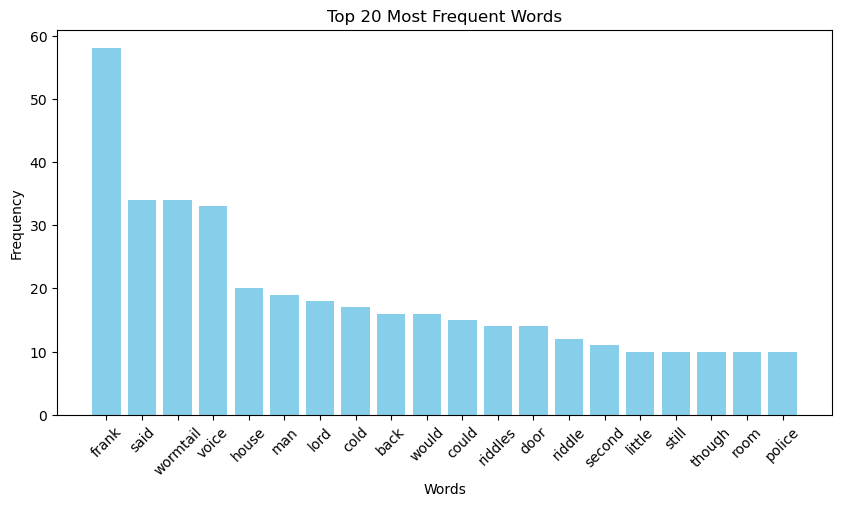

In [107]:
words, counts = zip(*word_freq_model[0].most_common(20))
plt.figure(figsize=(10, 5))
plt.bar(words, counts, color='skyblue')
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 20 Most Frequent Words")
plt.xticks(rotation=45)
plt.show()

In [157]:
# Part 3: Implement a Unigram, Bigram, and Trigram Models
def generate_ngrams(tokens, n):
    return list(ngrams(tokens,n))

# Get ngrams for each chapter iterating through the chapters
uni_chs = [generate_ngrams(tokens, 1) for tokens in filtered_chs]
bi_chs = [generate_ngrams(tokens, 2) for tokens in filtered_chs]
tri_chs = [generate_ngrams(tokens, 3) for tokens in filtered_chs]


#Ngram models for specific chapters

# Select a specific Chapter (let's pick chapter 1)
pick_ch_uni = uni_chs[0]
pick_ch_bi = bi_chs[0]
pick_ch_tri = tri_chs[0]

# Count frequencies for each ngram on a specific chapter
ch_uni_freq = Counter(pick_ch_uni)
ch_bi_freq = Counter(pick_ch_bi)
ch_tri_freq = Counter(pick_ch_tri)

# Convert to DataFrame for better readability
df_uni_ch = pd.DataFrame(ch_uni_freq.most_common(20), columns=["Unigram", "Frequency"])
df_bi_ch = pd.DataFrame(ch_bi_freq.most_common(20), columns=["Bigram", "Frequency"])
df_tri_ch = pd.DataFrame(ch_tri_freq.most_common(20), columns=["Trigram", "Frequency"])

# Print the top 20 most common ngrams in the specific chapter
print(f"Unigram Frequency for Chapter 1 (Top 20 Words): \n{df_uni_ch}")
print(f"\nBigram Frequency for Chapter 1 (Top 20 Words): \n{df_bi_ch}")
print(f"\nTrigram Frequency for Chapter 1 (Top 20 Words): \n{df_tri_ch}")



#Ngram models for the entire book

#Get ngrams for the entire book by each model
total_uni = [gram for chapter in uni_chs for gram in chapter]
total_bi = [gram for chapter in bi_chs for gram in chapter]
total_tri = [gram for chapter in tri_chs for gram in chapter]

#Count the frequencies for the entire book
uni_freq = Counter(total_uni)
bi_freq = Counter(total_bi)
tri_freq = Counter(total_tri)

# Convert to DataFrames for better readability
df_uni = pd.DataFrame(uni_freq.most_common(20), columns=["Unigram", "Frequency"])
df_bi = pd.DataFrame(bi_freq.most_common(20), columns=["Bigram", "Frequency"])
df_tri = pd.DataFrame(tri_freq.most_common(20), columns=["Trigram", "Frequency"])

# Print the top 20 most common ngrams in the entire book
print(f"\nUnigram Frequency in the entire book (Top 20 Words): \n{df_uni}")
print(f"\nBigram Frequency in the entire book (Top 20 Words): \n{df_bi}")
print(f"\nTrigram Frequency in the entire book (Top 20 Words): \n{df_tri}")

Unigram Frequency for Chapter 1 (Top 20 Words): 
        Unigram  Frequency
0       (said,)        124
1         (mr,)        107
2      (harry,)         78
3        (ron,)         56
4   (hermione,)         53
5    (weasley,)         40
6       (wand,)         36
7    (diggory,)         35
8     (crouch,)         32
9      (winky,)         31
10      (like,)         27
11    (looked,)         26
12      (dark,)         22
13       (got,)         21
14      (back,)         21
15   (wizards,)         21
16       (elf,)         21
17    (though,)         20
18      (mark,)         20
19       (get,)         19

Bigram Frequency for Chapter 1 (Top 20 Words): 
                 Bigram  Frequency
0         (mr, weasley)         38
1         (mr, diggory)         31
2          (mr, crouch)         30
3            (said, mr)         30
4           (said, ron)         19
5      (said, hermione)         18
6         (said, harry)         12
7          (dark, mark)         12
8          (harry, r

In [133]:
# Part 4: Implement TF Model

def generate_tf(token_freq, total_tokens):
    return {token: count/total_tokens for token, count in token_freq.items()} #Defining a function that takes as its input the token frequency and the total tokens for a specific chapter. Its output is the formula to calculate TF normalized. It will iterate for each chapter

# For Specific Chapters

# Compute TF scores per word for each chapter
ch_tf = [generate_tf(dict(token_freq), sum(token_freq.values())) for token_freq in word_freq_model] #using our function, we take specific token frequency and the sum of all tokens per chapter and run it through the output we defined. This gives us our TF score. Uses our Word Frequency model to grab the word's frequency

# Convert Chapter 1 TF into a DataFrame
df_tf_ch = pd.DataFrame(ch_tf[0].items(), columns=["Word", "TF"]).sort_values(by="TF", ascending=False).head(20) #Easier to visualize

# Print the top 20 scores for chapter 1 (define the chapter in code above)
print(f"\nTF Scores for Chapter 1 (Top 20 scores): \n{df_tf_ch}")


# For Entire Book

# Compute TF scores per word for the entire book
total_tokens_book = sum(total_word_freq_model.values()) #In our word freq code above, we did a total word freq model. We just take that and sum it to get the sum frequency of ALL the words
tf_book = generate_tf(total_word_freq_model, total_tokens_book) #We then put both variables in our function. The first is the frequency for each word, and the second is the sum of words

# Convert Book-Wide TF into a DataFrame
df_tf_book = pd.DataFrame(tf_book.items(), columns=["Word", "TF"]).sort_values(by="TF", ascending=False).head(20)

# Print the top 20 scores for the entire book
print(f"\nTF Scores for the entire book (Top 20 scores): \n{df_tf_book}")


TF Scores for Chapter 1 (Top 20 scores): 
         Word        TF
154     frank  0.027979
551  wormtail  0.016401
198      said  0.016401
529     voice  0.015919
6       house  0.009648
137       man  0.009165
535      lord  0.008683
97       cold  0.008201
450     would  0.007718
166      back  0.007718
92      could  0.007236
86    riddles  0.006753
209      door  0.006753
5      riddle  0.005789
538    second  0.005306
1      little  0.004824
8      though  0.004824
3       still  0.004824
101    police  0.004824
83       room  0.004824

TF Scores for the entire book (Top 20 scores): 
            Word        TF
668        harry  0.028957
198         said  0.026071
1343         ron  0.009685
1287    hermione  0.008153
166         back  0.005791
1295  dumbledore  0.005228
116           mr  0.005149
34        around  0.004843
431       looked  0.004773
404          one  0.004694
92         could  0.004388
191         like  0.004250
8         though  0.004151
416          got  0.004121

In [153]:
# Part 5: Implement TF-IDF Model

# Convert each chapter's tokens back to a string (for the vectorizer)
chs_text = [" ".join(tokens) for tokens in filtered_chs] #The vectorization requires string text data, can't be lists (which is what our tokenization is)

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english") #Can take chs_text because we made it a string. Creates a model with this

# Fit and transform the text into a TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(chs_text) #We have to transform each chapter into a matrix. Does the dirty work of assigning scores for EACH word in EACH chapter. Takes the formula and iterates for all
# It is a sparse matrix so lots of 0 values (word2vec is dense, so it will be different)
# Each row = Chapter
# Each column = Unique word
# Each cell = The TD-IDF score (if the word is zero, it does not appear in the chapter)

# Convert to DataFrame
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out()) #Easier to analyze. The higher the score, the better

# Print the matrix for the entire book
#print(f"\nTF-IDF matrix for the entire book: \n{df_tfidf}") #Gives us full matrix of scores across all chapters


# Function to get the top N words per chapter based on TF-IDF scores
def top_tfidf_words(ch_index, n = 10): # Asks for the input: first, chapter index (in our case it is 0 for chapter 1). Second, number of words (we want 20)
    ch_scores = df_tfidf.iloc[ch_index] # extracts exactly 1 chapter's scores (we can go on a chapter-by-chapter basis)
    return ch_scores.sort_values(ascending = False).head(n) # (highest to lowest), and only the specified number of words

# Get the top words for Chapter 1
df_top_tfidf_ch = top_tfidf_words(0, 20).reset_index() #Gets top 20 words for chapter 1 (you decide what you want)
df_top_tfidf_ch.columns = ["Word", "TF-IDF Score"] #renames coulmns

# Display the top TF-IDF words in Chapter 1
print(f"\nTF-IDF Scores for Chapter 1 (Top 20 scores): \n{df_top_tfidf_ch}")


#The big difference between TF and TF-IDF:
    # The TF model shows how important a word is within a document, but the TF-IDF model shows how important a word is relative to all documents
    # The TF model doesn't downweigh common words like "Harry," which appear in most chapters (probably all), but TF-IDF takes words that are unique and more meainingful and gives them special treatment based on how rare they are
    # For example, "triwizard" is only in specific chapters, so it has a high TF-IDF value for those contexts, highlighting its importance in those chapters
        #Another deeper example is that if Harry is in all chapters, it will have a high Term frequency, which means it is less informative across all chapters. In other words, no chapter (or document) is unique because it has "Harry" in it)
            # But a chapter that has "Triwizard" in it (let's say 6 chapters out of 37 have it) with a high frequency can tell us those chapters (or documents) are way more likely to be about "Triwards" because they are so uncommon

# In all, the TF-IDF model helps us find words that are meaningful to specific documents so we can label those specific documents based on those keywords, weighted to downplay super common words
# If you were to use TF, you could say, "Oh, this chapter is about Harry." Well, obviously
# But if you said, using TF-IDF, "Hey, this chapter is about Frank, or the triwizard, or Voldemort," That is WAY more valuable because they are uncommon



# Compare TF-IDF scores across chapters
top_tfidf_scores_ch = {}
for i in range(5):  # Compare first 5 chapters
    df_top_tfidf = top_tfidf_words(i, 10).reset_index()
    df_top_tfidf.columns = ["Word", "TF-IDF Score"]
    top_tfidf_scores_ch[f"Chapter {i+1}"] = df_top_tfidf

# Display the top TF-IDF words across the first 5 chapters
print(f"\nTF-IDF Scores across the first 5 chapters (Top 20 scores): \n{top_tfidf_scores_ch}")


TF-IDF Scores for Chapter 1 (Top 20 scores): 
         Word  TF-IDF Score
0       frank      0.772110
1    wormtail      0.255271
2     riddles      0.194323
3      riddle      0.127870
4      police      0.124534
5        said      0.119644
6       voice      0.116125
7        lord      0.110670
8         man      0.099152
9        cold      0.087312
10      house      0.078206
11    village      0.073950
12      stick      0.072015
13  hangleton      0.069401
14      bryce      0.062267
15       door      0.060911
16     nagini      0.057205
17        war      0.055521
18  villagers      0.049814
19    servant      0.047359

TF-IDF Scores across the first 5 chapters (Top 20 scores): 
{'Chapter 1':        Word  TF-IDF Score
0     frank      0.772110
1  wormtail      0.255271
2   riddles      0.194323
3    riddle      0.127870
4    police      0.124534
5      said      0.119644
6     voice      0.116125
7      lord      0.110670
8       man      0.099152
9      cold      0.087312, 'Ch